<a href="https://colab.research.google.com/github/ITboxer/MachineLearning/blob/main/8_CNN_with_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network with CIFAR-10

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## 데이터 전처리

In [3]:
# cifar-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# 32x32 pixel, 3 channels (RGB), values: 0~255
x_train = x_train / 255.0
x_train = x_train.reshape(-1, 32, 32, 3).astype(np.float32) # CIFAR-10 = 32 x 32 형식
x_test = x_test / 255.0
x_test = x_test.reshape(-1, 32, 32, 3).astype(np.float32)

# 10 classes
class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

170500096/170498071 [==============================] - 4s 0us/step


In [4]:
x_train.shape # 50000 training images, 32x32 pixels, 3 channels, (0~255)

(50000, 32, 32, 3)

In [5]:
y_train.shape # 50000 labels, 1 dim for class (0~9)

(50000, 1)

In [6]:
x_test.shape # 10000 test images.

(10000, 32, 32, 3)

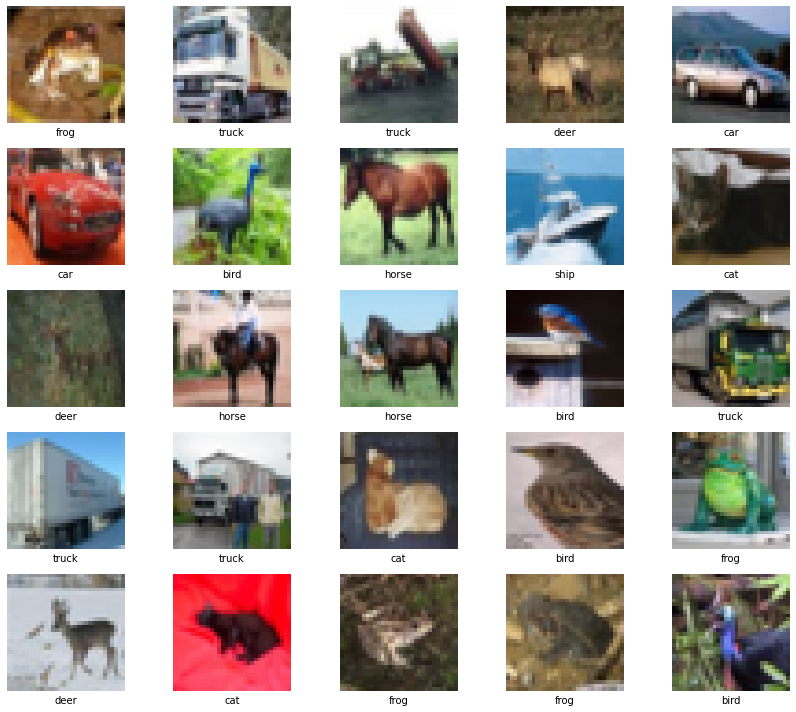

In [7]:
# 데이터셋 확인
n = (5, 5)

# 5x5개의 데이터셋 이미지와 class를 확인합니다.
fig, ax = plt.subplots(n[0],n[1],figsize=(12, 10))

for i in range(n[0] * n[1]):
    elem = i
    row = i // n[1]
    col = i % n[1]
    ax[row][col].imshow(x_train[elem].reshape(32,32,3), vmin=0, vmax=1)
    ax[row][col].set(xticks=[], yticks=[], frame_on=False)
    ax[row][col].set(xlabel="{}".format(class_names[y_train[elem].item()])) 
fig.tight_layout() 

plt.show()

## 모델 구성

In [8]:
# Parameters
learning_rate = 0.001
num_epochs = 20
batch_size = 128

# Network Parameters
img_shape = (32, 32) # CIFAR10 data input (img shape: 32x32)
num_class = 10

In [9]:
from tensorflow.keras import Model, layers

class CNNModel(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = layers.Conv2D(32,3, activation='relu', padding="same", input_shape=(32,32,3))
        self.conv2 = layers.Conv2D(64,3, activation='relu', padding="same")
        self.maxpool = layers.MaxPool2D((2,2))
        self.flatten = layers.Flatten()
        self.dropoutc = layers.Dropout(0.3)
        self.dropoutd = layers.Dropout(0.5)
        self.d1 = layers.Dense(256, activation='relu')
        self.d2 = layers.Dense(10)
        self.bn1 = layers.BatchNormalization(momentum=0.9)
        self.bn2 = layers.BatchNormalization(momentum=0.9)
        self.bn3 = layers.BatchNormalization(momentum=0.9)

    def call(self, x):
        x = tf.reshape(x, [-1, 32, 32, 3])
        
        # convolution layer (32x32, 3channel) + activation (relu) + batch normalization + max pooling + dropout (0.5)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.maxpool(x)
        x = self.dropoutc(x)
        
        # convolution layer (64x64, 3channel) + activation (relu) + batch normalization + max pooling + dropout (0.3)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.maxpool(x)
        x = self.dropoutc(x)
        
        # dense layer (256 dimension) + activation (relu) + batch normalization + dropout (0.5)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.bn3(x)
        x = self.dropoutd(x)
        
        # dense layer (10 dimension)
        x = self.d2(x)
        return x

In [10]:
# 데이더셋 로더 (batch size, shuffling)

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(x_train.shape[0]).batch(batch_size)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

In [11]:
# 모델 평가 (loss, 정확도)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="test_accuracy")

In [12]:
# 최적화 목적 함수 (cross entropy loss)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# 최적화 알고리즘 (Adam)

optimizer = tf.keras.optimizers.Adam(learning_rate)

In [13]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # 모형에 데이터를 넣어서 예측 값을 얻음
        predictions = model(images, training=True)  # training이 True일 경우 dropout 사용
        
        # 최적화 목표함수를 기준으로 예측 값을 평가 (loss를 구함)
        loss = loss_object(labels, predictions)
    
    # loss를 최소화하는 기울기(gradient)를 계산함.
    gradients = tape.gradient(loss, model.trainable_variables)
    
    # 기울기를 바탕으로 모형 파라미터를 수정함
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    # loss, accuracy 기록
    train_loss(loss)
    train_accuracy(labels, predictions)

@tf.function
def test_step(images, labels):
    predictions = model(images, training=False)  # training이 False일 경우 dropout 사용 안함
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [14]:
model = CNNModel()

In [15]:
loss_history = []
acc_history = []

for epoch in range(num_epochs):
    # loss, accuracy 기록 리셋
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    # training 데이터셋으로 학습
    for images, labels in train_ds:
        train_step(images, labels)

    # test 데이터셋으로 성능 평가
    for images, labels in test_ds:
        test_step(images, labels)
        
    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
        f'Accuracy: {train_accuracy.result() * 100}, '
        f'Test Loss: {test_loss.result()}, '
        f'Test Accuracy: {test_accuracy.result() * 100}'
    )
    
    acc_history.append(test_accuracy.result())
    loss_history.append(test_loss.result())

Epoch 1, Loss: 1.668596863746643, Accuracy: 44.2400016784668, Test Loss: 1.2808412313461304, Test Accuracy: 54.73999786376953
Epoch 2, Loss: 1.1950414180755615, Accuracy: 57.624000549316406, Test Loss: 1.933774709701538, Test Accuracy: 44.150001525878906
Epoch 3, Loss: 1.0517586469650269, Accuracy: 62.8380012512207, Test Loss: 1.0741503238677979, Test Accuracy: 61.6199951171875
Epoch 4, Loss: 0.9738516807556152, Accuracy: 65.76799774169922, Test Loss: 0.9933091402053833, Test Accuracy: 66.27999877929688
Epoch 5, Loss: 0.9157695174217224, Accuracy: 67.78800201416016, Test Loss: 0.9945347309112549, Test Accuracy: 67.72999572753906
Epoch 6, Loss: 0.8707931637763977, Accuracy: 69.36399841308594, Test Loss: 0.9304286241531372, Test Accuracy: 70.31000518798828
Epoch 7, Loss: 0.8317984938621521, Accuracy: 70.65599822998047, Test Loss: 0.9066928625106812, Test Accuracy: 69.58000183105469
Epoch 8, Loss: 0.8000063896179199, Accuracy: 71.80000305175781, Test Loss: 0.8436203002929688, Test Accurac

In [16]:
y_predicted = model(x_test, training=False)
y_predicted = tf.math.argmax(y_predicted, 1)
y_predicted.numpy()  # 모형 예측값

array([3, 8, 8, ..., 5, 1, 7])

In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# precision, recall, f1-score
report = classification_report(y_true=y_test, y_pred=y_predicted, target_names=class_names)
print(report)

              precision    recall  f1-score   support

    airplane       0.86      0.71      0.78      1000
         car       0.90      0.85      0.88      1000
        bird       0.65      0.67      0.66      1000
         cat       0.64      0.51      0.57      1000
        deer       0.67      0.81      0.74      1000
         dog       0.76      0.61      0.68      1000
        frog       0.73      0.91      0.81      1000
       horse       0.87      0.79      0.83      1000
        ship       0.78      0.92      0.84      1000
       truck       0.83      0.85      0.84      1000

    accuracy                           0.76     10000
   macro avg       0.77      0.76      0.76     10000
weighted avg       0.77      0.76      0.76     10000



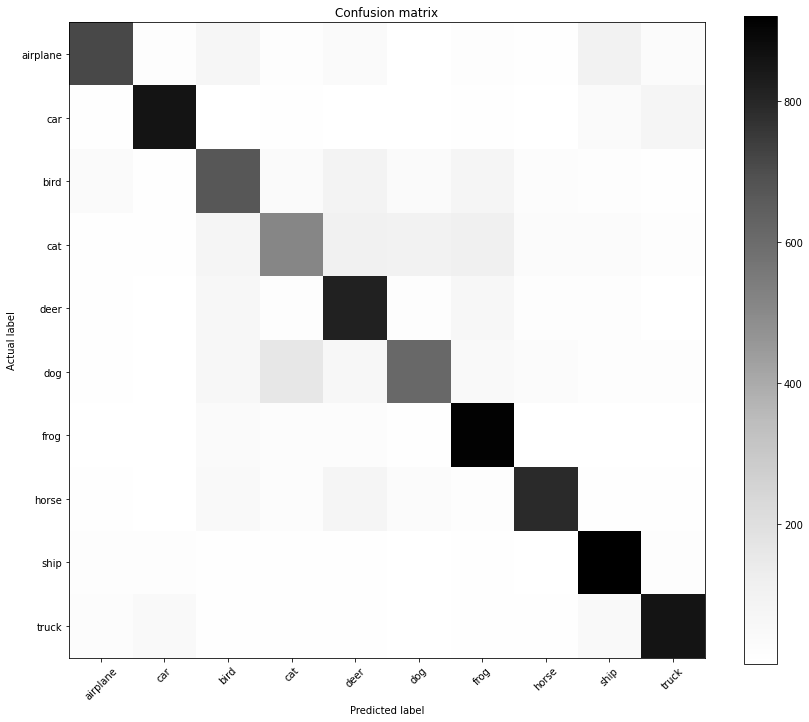

In [18]:
# confusion matrix

conf = confusion_matrix(y_true=y_test, y_pred=y_predicted)

plt.figure(figsize=(12,10))
plt.imshow(conf, cmap=plt.cm.Greys, interpolation="nearest")
plt.title("Confusion matrix")

plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.tight_layout()
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

plt.show()

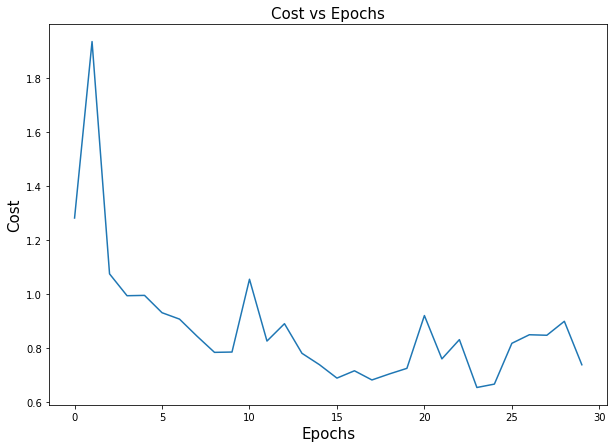

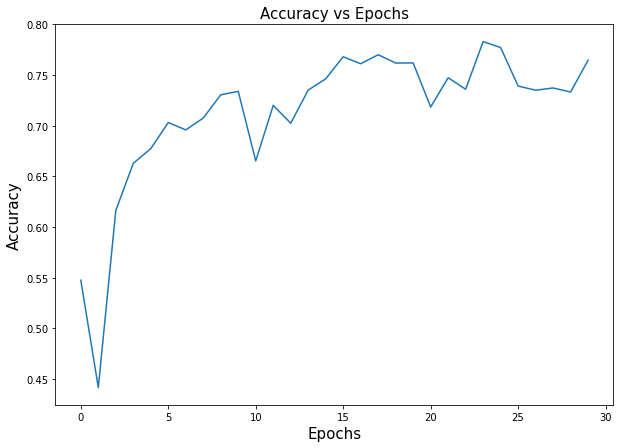

In [19]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(loss_history)
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Cost', fontsize = 15)
plt.title('Cost vs Epochs', fontsize=15)
plt.show()

fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(acc_history)
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.title('Accuracy vs Epochs', fontsize=15)
plt.show()

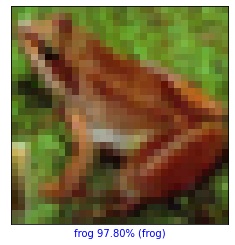

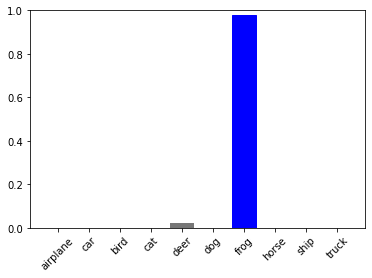

In [20]:
# 데이터를 잘 분류하고 있는지 확인

number = 29
prediction = x_test[number]
true_label = y_test[number]
plt.figure()
plt.imshow(prediction.reshape(32,32,3))
plt.xticks([])
plt.yticks([])
# plt.show()

predict = model(prediction, training=False)
predicted_label = tf.math.argmax(predict, 1)
predicted_label = predicted_label.numpy().item()
true_label = true_label.item()
predict = tf.nn.softmax(predict).numpy().squeeze()

if predicted_label == true_label:
    color = 'blue'
else:
    color = 'red'
    
plt.xlabel("{} {:2.2f}% ({})".format(class_names[predicted_label],100*np.max(predict),class_names[true_label]),color=color)

plt.figure()
thisplot = plt.bar(range(10), predict, color="#777777")
plt.ylim([0, 1])
plt.xticks(range(10), class_names, rotation=45)
predicted_label = np.argmax(predict)
thisplot[predicted_label].set_color('red')
thisplot[true_label].set_color('blue')